## Anomaly Detection- windowed method 

In [2]:
import numpy as np
import pickle
import pandas as pd
import keras
from keras import layers
from matplotlib import pyplot as plt
import tensorflow as tf
from keras.layers import Lambda, Input, Dense, Dropout
from utils.functions import sample, create_sequences, get_error_term
from model.vae_window import vae_window

Importing the dataset

In [3]:
data = pd.read_csv("data/realKnownCause/realKnownCause/machine_temperature_system_failure.csv",
                   parse_dates=True, index_col="timestamp")

In [4]:
with open('lists.pkl', 'rb') as f:
    lists = pickle.load(f)

# Access the lists
instances_of_anomaly= lists[0]

In [5]:
data_with_anomaly = data.copy()
data_with_anomaly['anomaly'] = 0
for instance in instances_of_anomaly: 
    start = pd.to_datetime(instance[0])
    end = pd.to_datetime(instance[1])
    data_with_anomaly.loc[(data_with_anomaly.index >= start) & (data_with_anomaly.index <= end), 'anomaly'] = 1

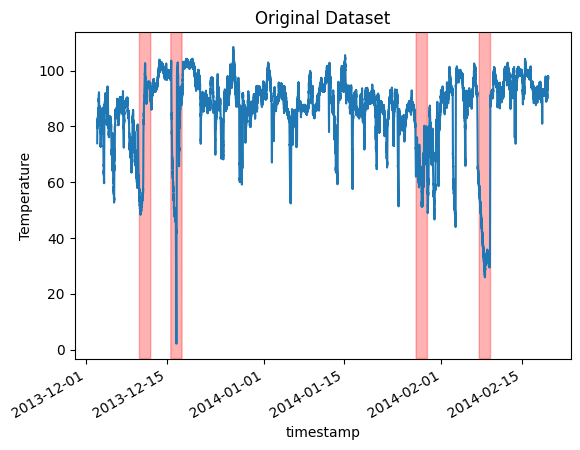

In [6]:
fig, ax = plt.subplots()
data.plot(legend=False, ax=ax)
ax.fill_between(data_with_anomaly.index, 0, 1, where=data_with_anomaly['anomaly'], color='red', alpha=0.3, transform=ax.get_xaxis_transform(), label='Real anomaly')
plt.ylabel("Temperature")
plt.title("Original Dataset")
plt.show()

Splitting training and testing

In [7]:
# Splitting to train and test
test_ratio =0.3
start = int(len(data) * 0.25 )  # or 0 
tr_data = data.iloc[start: int(len(data) * (1 - test_ratio))]
tst_data1 = data.iloc[int(len(data) * (1 - test_ratio)) :]
tst_data2 = data.iloc[0:start]

In [8]:
tr_data

,value
timestamp,
2013-12-22 14:00:00,87.168898
2013-12-22 14:05:00,87.933798
2013-12-22 14:10:00,85.804768
2013-12-22 14:15:00,85.955663
2013-12-22 14:20:00,86.815269
...,...
2014-01-26 23:40:00,88.470506
2014-01-26 23:45:00,88.395883
2014-01-26 23:50:00,88.608302


Normailzing the training set 

In [9]:
# Normalize and save the mean and std we get, for normalizing test data.
training_mean = tr_data.mean()
training_std = tr_data.std()
train_scaled = (tr_data - training_mean) / training_std
print("Number of training samples:", len(train_scaled))

Number of training samples: 10213


Function to create the windowed data

In [10]:
step_size = 288

train = create_sequences(train_scaled.values, step_size)
print("Training input shape: ", train.shape)

Training input shape:  (9926, 288, 1)


VAE model

In [11]:
vae = vae_window(train, latent_dim=8)

In [12]:
vae.summary()

Model: "vae"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 288, 1)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d (Conv1D)     │ (None, 144, 32)   │        256 │ input_layer[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 144, 32)   │          0 │ conv1d[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_1 (Conv1D)   │ (None, 72, 16)    │      3,600 │ dropout[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder             │ [(None, 8),       │     22,304 │ input_layer[0][0] │
│ (Functional)        │ (None, 8), (None, │            │                   │
│                     │ 8)]               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten (Flatten)   │ (None, 1152)      │          0 │ conv1d_1[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ decoder             │ (None, 288, 1)    │     59,553 │ encoder[0][2]     │
│ (Functional)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ z_mean (Dense)      │ (None, 8)         │      9,224 │ flatten[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ z_log_var (Dense)   │ (None, 8)         │      9,224 │ flatten[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ vae_loss_layer      │ (None, 288, 1)    │          0 │ input_layer[0][0… │
│ (VAELossLayer)      │                   │            │ decoder[0][0],    │
│                     │                   │            │ z_mean[0][0],     │
│                     │                   │            │ z_log_var[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 81,857 (319.75 KB)

 Trainable params: 81,857 (319.75 KB)

 Non-trainable params: 0 (0.00 B)

In [13]:
history = vae.fit(
    train,
    train,
    epochs=50,
    batch_size=128,
    validation_split=0.2,
    callbacks=[tf.keras.callbacks.EarlyStopping(patience=8, restore_best_weights=True)])

Epoch 1/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - loss: 28767.8262 - val_loss: 9313.0684
Epoch 2/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 6647.5908 - val_loss: 3788.8459
Epoch 3/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 3637.8374 - val_loss: 2835.9360
Epoch 4/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 2806.1379 - val_loss: 2379.1802
Epoch 5/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 2426.3076 - val_loss: 2280.3191
Epoch 6/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 2151.4360 - val_loss: 2194.1765
Epoch 7/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 1976.0135 - val_loss: 2498.6204
Epoch 8/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 1921.7777 - val_loss: 2299.5637
Epoch 9/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 1738.4025 - val_loss: 2290.2170
Epoch 10/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 1682.8656 - val_loss: 2394.3418
Epoch 11/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 1616.4866 - val_loss: 2484.5

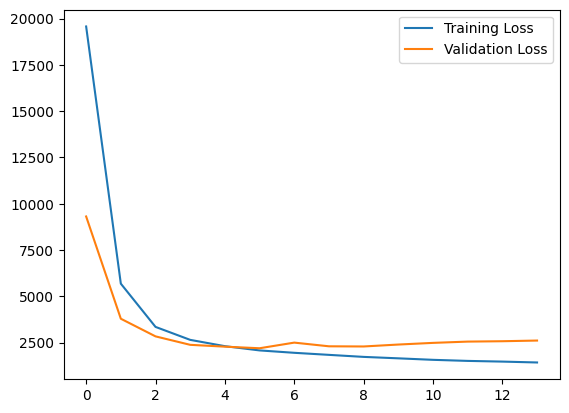

In [14]:
plt.plot(history.history["loss"], label="Training Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.legend()
plt.show()

311/311 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
(9926, 1)


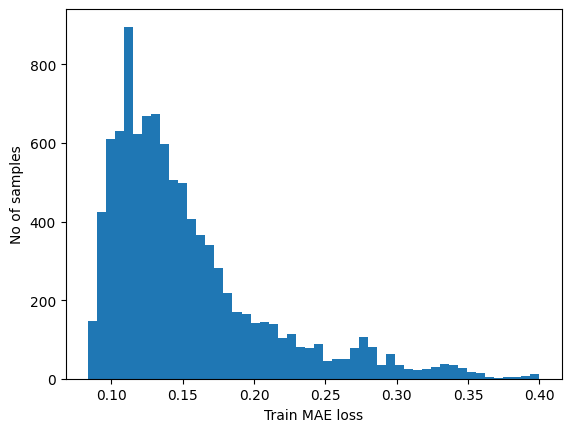

Reconstruction error threshold:  0.39981199326721917


In [15]:
# Get train MAE loss.
train_pred = vae.predict(train)[0]
train_mae_loss = np.mean(np.abs(train_pred - train), axis=1)
print(train_mae_loss.shape)
plt.hist(train_mae_loss, bins=50)
plt.xlabel("Train MAE loss")
plt.ylabel("No of samples")
plt.show()

# Get reconstruction loss threshold.
threshold = np.max(train_mae_loss)
print("Reconstruction error threshold: ", threshold)

In [16]:
print(train_pred.shape)

(9926, 288, 1)


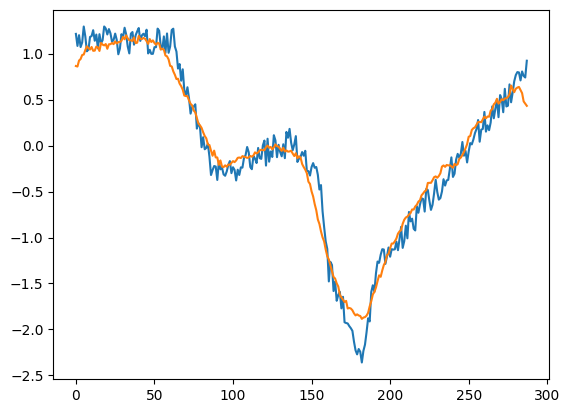

In [17]:
# Checking how the first sequence is learnt
plt.plot(train[90])
plt.plot(train_pred[90])
plt.show()

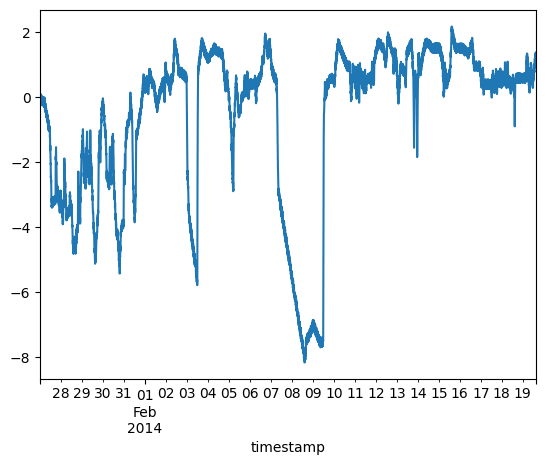

Test input shape:  (6522, 288, 1)
204/204 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
(6522, 1)


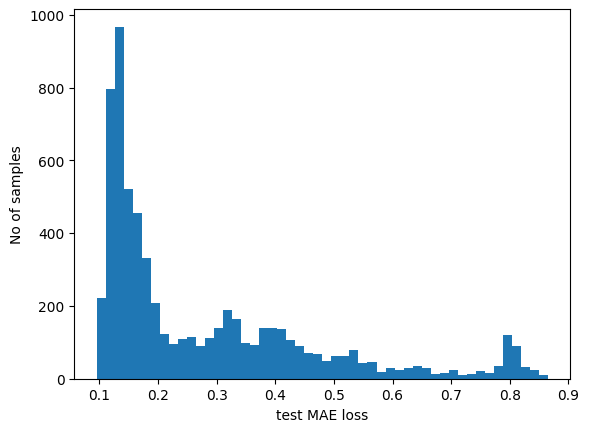

Number of anomaly samples:  1445
Indices of anomaly samples:  (array([  70,   71,   72, ..., 3817, 3818, 3876], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64))


In [18]:

tst_data= tst_data1          #1 or 2
test_scaled = (tst_data - training_mean) / training_std
fig, ax = plt.subplots()
test_scaled.plot(legend=False, ax=ax)
plt.show()

# Create sequences from test values.
test = create_sequences(test_scaled.values, step_size)
print("Test input shape: ", test.shape)

# Get test MAE loss.
test_pred = vae.predict(test)[0]
test_mae_loss = np.mean(np.abs(test_pred - test), axis=1)
print(test_mae_loss.shape)
#test_mae_loss = test_mae_loss.reshape((-1))

plt.hist(test_mae_loss, bins=50)
plt.xlabel("test MAE loss")
plt.ylabel("No of samples")
plt.show()

# Detect all the samples which are anomalies.
anomalies = test_mae_loss > threshold
print("Number of anomaly samples: ", np.sum(anomalies))
print("Indices of anomaly samples: ", np.where(anomalies))

In [19]:
# data i is an anomaly if samples [(i - timesteps + 1) to (i)] are anomalies
anomalous_data_indices = []
for data_idx in range(step_size - 1, len(test_scaled) - step_size + 1):
    if np.all(anomalies[data_idx - step_size + 1 : data_idx]):
        anomalous_data_indices.append(data_idx)

In [20]:
# # data i is an anomaly if more than 90% of samples [(i - timesteps + 1) to (i)] are anomalies
# anomalous_data_indices = []
# for data_idx in range(step_size - 1, len(test_scaled) - step_size + 1):
#     if np.sum(anomalies[data_idx - step_size + 1 : data_idx]) > step_size * 0.9:
#         anomalous_data_indices.append(data_idx)

In [21]:
print("Indices of anomalies: ", anomalous_data_indices)

Indices of anomalies:  [3432, 3433, 3434, 3435, 3436, 3437, 3438, 3439, 3440, 3441, 3442, 3443, 3444, 3445, 3446, 3447, 3448, 3449, 3450, 3451, 3452, 3453, 3454, 3455, 3456, 3457, 3458, 3459, 3460, 3461, 3462, 3463, 3464, 3465, 3466, 3467, 3468, 3469, 3470, 3471, 3472, 3473, 3474, 3475, 3476, 3477, 3478, 3479, 3480, 3481, 3482, 3483, 3484, 3485, 3486, 3487, 3488, 3489, 3490, 3491, 3492, 3493, 3494, 3495, 3496, 3497, 3498, 3499, 3500, 3501, 3502, 3503, 3504, 3505, 3506, 3507, 3508, 3509, 3510, 3511, 3512, 3513, 3514, 3515, 3516, 3517, 3518, 3519, 3520, 3521, 3522, 3523, 3524, 3525, 3526, 3527, 3528, 3529, 3530, 3531, 3532, 3533, 3534, 3535, 3536, 3537, 3538, 3539, 3540, 3541, 3542, 3543, 3544, 3545, 3546, 3547, 3548, 3549, 3550, 3551, 3552, 3553, 3554, 3555, 3556, 3557, 3558, 3559, 3560, 3561, 3562, 3563, 3564, 3565, 3566, 3567, 3568, 3569, 3570, 3571, 3572, 3573, 3574, 3575, 3576, 3577, 3578, 3579, 3580, 3581, 3582, 3583, 3584, 3585, 3586, 3587, 3588, 3589, 3590, 3591, 3592, 3593, 3594

In [22]:
df_subset = tst_data.iloc[anomalous_data_indices]
df_subset

,value
timestamp,
2014-02-07 22:05:00,48.465137
2014-02-07 22:10:00,48.928193
2014-02-07 22:15:00,47.535372
2014-02-07 22:20:00,47.442748
2014-02-07 22:25:00,48.501459
...,...
2014-02-09 02:40:00,32.830385
2014-02-09 02:45:00,32.538906
2014-02-09 02:50:00,33.876513


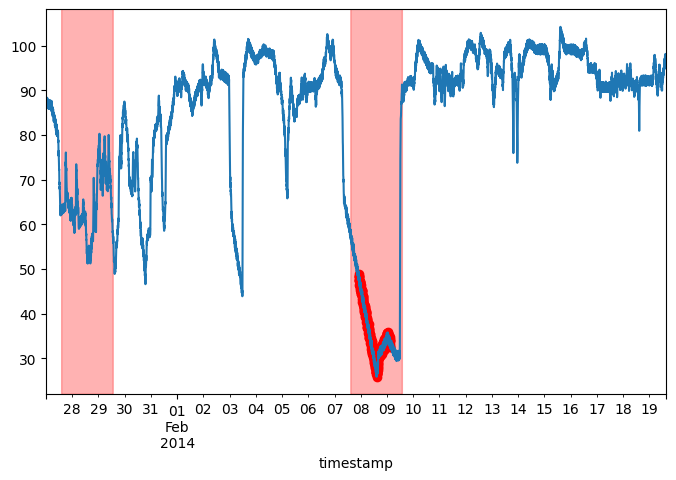

In [23]:
fig, ax = plt.subplots(1,1, figsize=(8, 5))
tst_data.plot(legend=False, ax=ax)
ax.fill_between(data_with_anomaly.index, 0, 1, where=data_with_anomaly['anomaly'], color='red', alpha=0.3, transform=ax.get_xaxis_transform(), label='Real anomaly')
ax.scatter(df_subset.index, df_subset['value'], color="r")
plt.show()